## Setup

Choose the target board. For the time being, you can use `minized`, `pynqz1`, `pynqz2`, `cmoda735t`. You may need to install the proper board files for the chosen board.

In [1]:
## ZCU106
#board_name='zcu106'
#fpga_part='xczu7ev-ffvc1156-2-e'
 
## Ultra96
#board_name='ultra96'
#fpga_part='xczu3eg-sbva484-1-e'

## Pynq-Z1
board_name='pynqz1'
fpga_part='xc7z020clg400-1'

## Pynq-Z2
#board_name='pynqz2'
#fpga_part='xc7z020clg400-1'

## MiniZed
#board_name='minized'
#fpga_part='xc7z007sclg225-1'

##Cmod A7-35t
#board_name='cmoda735t'
#fpga_part='xc7a35tcpg236-1'

## Arty A7-100t
#board_name='artya7100t'
#fpga_part='xc7a100t-csg324-1'

## Arty A7-35t
#board_name='artya735t'
#fpga_part='xc7a35ticsg324-1L'

Add the project name. The notebook will create sub-directories for the Vivado projects with different models and configurations.

In [2]:
acc_name='anomaly_detector'

Let's import the libraries, call the magic functions, and setup the environment variables.

In [3]:
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects

import numpy as np

import hls4ml

from callbacks import all_callbacks
import plotting

import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


## Load the dataset

This is a lot like the previous notebooks, so we will go through quickly.

First, we fetch the dataset from file, do the normalization and make a train and test split.

We save the test dataset to files so that we can use them later.

In [4]:
#X_npy = './test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0.npy'
#y_npy = './test_data/test_data_frames_4_hops_512_fft_1024_mels_64_power_2.0_ground_truths.npy'

X_npy = './test_data/downsampled_128_5_to_32_4_skip_method.npy'
y_npy = './test_data/downsampled_128_5_to_32_4_ground_truths_skip_method.npy'

In [5]:
#load processed test data
from sklearn.utils import shuffle
X = np.load(X_npy, allow_pickle=True)
y = np.load(y_npy, allow_pickle=True)
y_keras = []
#use a quarter of the test_set to save time
for i in range(len(X)):
    quarter = int(len(X[i])/4)
    assert len(X) == len(y)
    #X[i], y[i] = shuffle(X[i], y[i])
    X[i], y[i] = X[i][0:quarter],  y[i][0:quarter]

## Train or Load Model

In [6]:
import keras_model
train = False
#not os.path.exists('model/KERAS_check_best_model.h5')
if train:
    model.compile(loss="mean_squared_error", optimizer="adam")
        
    print("Shape of training data element is: {}".format(train_data[0].shape))
    history = model.fit(train_data,
                        train_data,
                        epochs=100,
                        batch_size=512,
                        shuffle=true,
                        validation_split=0.1,
                        verbose=1,
                        callbacks=callbacks)
    

else:
    #model_file = 'model/train_config_bits_6_frames_4_mels_64_hidDims_64_encDims_8_bn_True_l1reg0/model_ToyCar.h5'
    #model_file = "model/tiny_qkeras_model/train_config_bits_6_frames_4_mels_64_encDims_8_hidDims_64_bn_True_qbatch_False_l1reg_0/model_ToyCar.h5"
    #model_file = 'model/train_config_bits_6_frames_5_mels_128_encDims_8_hidDims_64_halfcode_2_fan_64_bn_True_qbatch_False_l1reg_0/keras_model.h5'
    
    # AD01
    #model_file = 'model/train_config_bits_7_frames_5_mels_128_encDims_8_hidDims_64_halfcode_2_fan_64_bn_True_qbatch_False_l1reg_0/keras_model.h5'
    
    # AD02
    #model_file = 'model/train_config_bits_8_frames_5_mels_128_encDims_8_hidDims_64_halfcode_2_fan_64_bn_True_qbatch_False_l1reg_0/keras_model.h5'
    
    # AD03
    model_file = 'model/train_config_bits_10_frames_5_mels_128_encDims_8_hidDims_64_halfcode_1_fan_64_bn_True_qbatch_False_l1reg_0/keras_model.h5'
    
    # AD04
    #model_file = 'model/ad04/keras_model.h5'
    
    if not os.path.exists(model_file):
        print("{} model not found at path ".format(model_file))

    model = keras_model.load_model(model_file)

model.summary()    

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
q_dense (QDense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
q_activation (QActivation)   (None, 64)                0         
_________________________________________________________________
q_dense_1 (QDense)           (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
q_activation_1 (QActivation) (None, 64)               

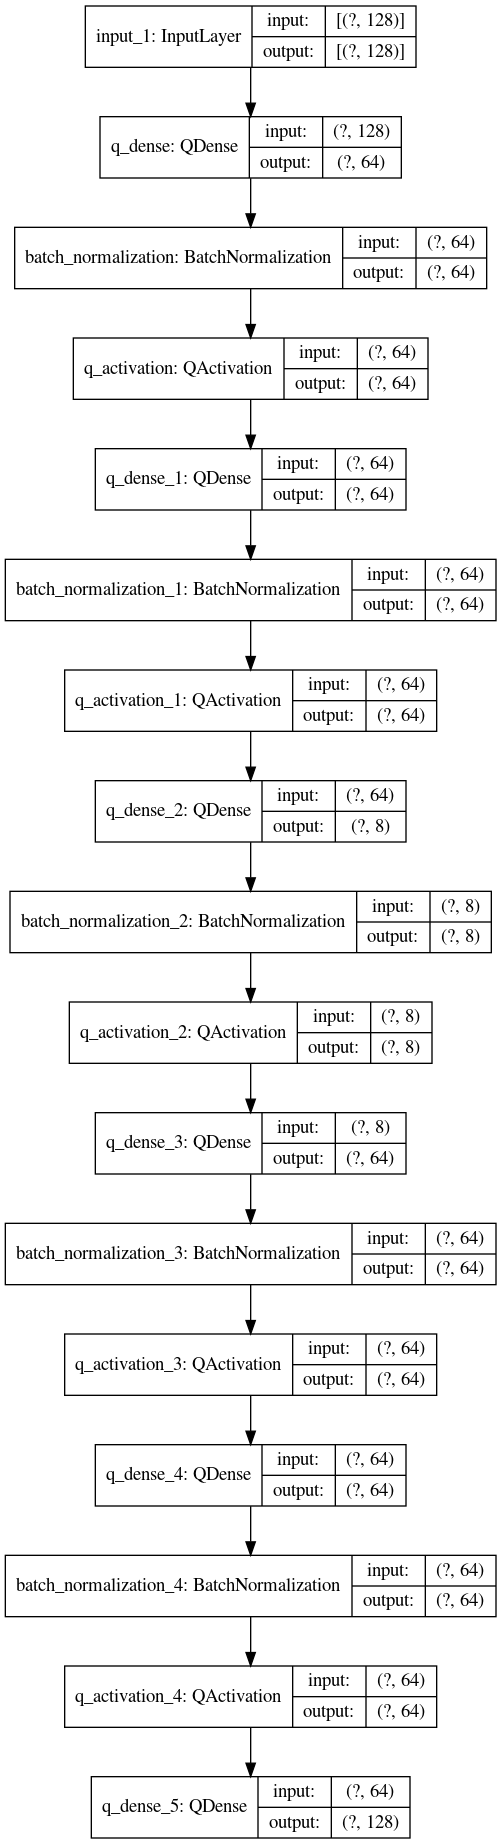

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

## Check model sparisty

% of zeros = 0.0


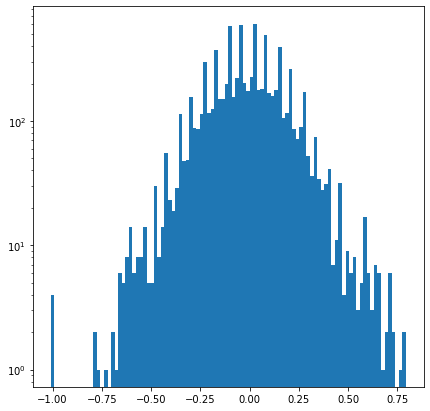

In [8]:
w = model.layers[1].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

## Check accuracy

Do not expect a good accuracy because of the low amount of neurons. I could have done better than this, but as long as it fits both Pynq-Z1 and MiniZed, it is fine with us.

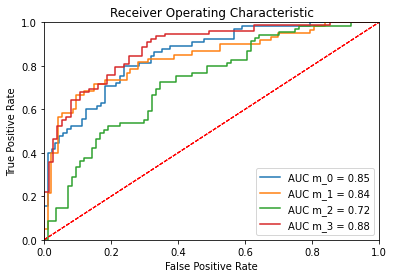

In [9]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
import plotting
import numpy

#load processed test data
X = np.load(X_npy, allow_pickle=True)
y = np.load(y_npy, allow_pickle=True)
y_keras = []
#use a quarter of the test_set to save time
for i in range(len(X)):
    quarter = int(len(X[i])/4)
    assert len(X) == len(y)
    X[i], y[i] = shuffle(X[i], y[i])
    X[i], y[i] = X[i][0:quarter],  y[i][0:quarter]

#perform inference
for index, X_data in enumerate(X):
    y_pred = [0. for ind in X_data]
    for file_idx, X_test in enumerate(X_data):
        predictions = model.predict(X_test)
        errors = np.mean(np.square(X_test-predictions), axis=1)
        y_pred[file_idx] = numpy.mean(errors)
        
    #generate auc and roc metrics
    y_test = y[index]
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    y_keras.append(y_pred)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = 'AUC m_{} = {}'.format(index, round(roc_auc,2)), linewidth = 1.5)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', linewidth=1)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()


## Make an hls4ml configuration

Notice we're using `Strategy: Resource` for every layer, and `ReuseFactor: 64`. The Programmable Logic (FPGA part) of the Pynq-Z1 SoC is not big compared to VU9P type of parts.

We also use some settings which are good for QKeras.

Notice the `fpga_part:'xc7z020clg400-1'`.

In [10]:
import yaml

def yaml_load(config):
    with open(config, 'r') as stream:
        param = yaml.safe_load(stream)
    return param

hls_config = yaml_load('model/ad03/hls4ml_config.yml')
hls_config = hls_config['HLSConfig']

hls_config['Model']['ReuseFactor'] = 4096


print("-----------------------------------")
plotting.print_dict(hls_config)
print("-----------------------------------")

-----------------------------------
LayerName
  batch_normalization
    Precision
      bias:          ap_fixed<16,6>
      scale:         ap_fixed<16,6>
    ReuseFactor:     4096
    Trace:           True
  batch_normalization_1
    Precision
      bias:          ap_fixed<16,6>
      scale:         ap_fixed<16,6>
    ReuseFactor:     4096
    Trace:           True
  batch_normalization_2
    Precision
      bias:          ap_fixed<16,6>
      scale:         ap_fixed<16,6>
    ReuseFactor:     4096
    Trace:           True
  batch_normalization_3
    Precision
      bias:          ap_fixed<16,6>
      scale:         ap_fixed<16,6>
    ReuseFactor:     4096
    Trace:           True
  batch_normalization_4
    Precision
      bias:          ap_fixed<16,6>
      scale:         ap_fixed<16,6>
    ReuseFactor:     4096
    Trace:           True
  input_1
    Precision:       ap_fixed<8,8>
    ReuseFactor:     4096
    Trace:           True
  q_activation
    Precision
      result:       

## Convert and Compile

You can set some target specific configurations:

- Define the `interface`, which for our current setup should always be `m_axi`.
- Define the  width of the AXI bus. For the time being, use `16` that is each clock cycle you transfer a single input or output value (`ap_fixed<16,*>`).
- Define the implementation. For the time being, use `serial`.

In [11]:
interface = 'm_axi' # 's_axilite', 'm_axi', 'hls_stream'
axi_width = 8 # 16, 32, 64
implementation = 'serial' # 'serial', 'dataflow'

In [12]:
#output_dir='hls/' + '256x16x8x256_' + '_' + interface + '_' + str(axi_width) + '_' + implementation + '_prj'
output_dir='hls/' + board_name + '_' + acc_name + '_' + interface + '_' + str(axi_width) + '_' + implementation + '_prj' 

backend_config = hls4ml.converters.create_backend_config(fpga_part=fpga_part)
backend_config['ProjectName'] = acc_name
backend_config['KerasModel'] = model
backend_config['HLSConfig'] = hls_config
backend_config['OutputDir'] = output_dir
backend_config['Backend'] = 'Pynq'
backend_config['Interface'] = interface
backend_config['IOType'] = 'io_parallel'
backend_config['AxiWidth'] = str(axi_width)
backend_config['Implementation'] = implementation
backend_config['ClockPeriod'] = 10

#print("-----------------------------------")
#plotting.print_dict(backend_config)
#print("-----------------------------------")

hls_model = hls4ml.converters.keras_to_hls(backend_config)
# hls_model = hls4ml.converters.convert_from_keras_model(model,
#                                                                 hls_config=hls_config,
#                                                                 output_dir=output_dir,
#                                                                 fpga_part=fpga_part,
#                                                                 clock_period=10,
#                                                                 io_type='io_parallel',
#                                                                 project_name='anomaly_detector')

_ = hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, current shape: [[None, 128]]
Layer name: q_dense, layer type: QDense, current shape: [[None, 128]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 64]]
Layer name: q_activation, layer type: Activation, current shape: [[None, 64]]
Layer name: q_dense_1, layer type: QDense, current shape: [[None, 64]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 64]]
Layer name: q_activation_1, layer type: Activation, current shape: [[None, 64]]
Layer name: q_dense_2, layer type: QDense, current shape: [[None, 64]]
Layer name: batch_normalization_2, layer type: BatchNormalization, current shape: [[None, 8]]
Layer name: q_activation_2, layer type: Activation, current shape: [[None, 8]]
Layer name: q_dense_3, layer type: QDense, current shape: [[None, 8]]
Layer name: batch_normalization_3, layer type: BatchNormalization, current shape: [[None, 64]]
L

## Profiling

In [13]:
%%time
%matplotlib inline

# Run tracing on a portion of the test set for the hls model (fixed-point precision) 
hls4ml_pred, hls4ml_trace = hls_model.trace(np.ascontiguousarray(X[0][0][0]))

# Run tracing on a portion of the test set for the Keras model (floating-point precision)
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X[0][0])

# Run prediction on a portion of the test set for the hls model (fixed-point precision)
#y_hls = hls_model.predict(np.ascontiguousarray(X[0][0][0]))

#_ = hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=X[0][0])

Recompiling anomaly_detector with tracing
Writing HLS project
Done
Processing input_1 in Keras model...
Processing q_dense in Keras model...
Processing batch_normalization in Keras model...
Processing q_activation in Keras model...
Processing q_dense_1 in Keras model...
Processing batch_normalization_1 in Keras model...
Processing q_activation_1 in Keras model...
Processing q_dense_2 in Keras model...
Processing batch_normalization_2 in Keras model...
Processing q_activation_2 in Keras model...
Processing q_dense_3 in Keras model...
Processing batch_normalization_3 in Keras model...
Processing q_activation_3 in Keras model...
Processing q_dense_4 in Keras model...
Processing batch_normalization_4 in Keras model...
Processing q_activation_4 in Keras model...
Processing q_dense_5 in Keras model...
Done taking outputs for Keras model.
CPU times: user 7.22 s, sys: 84.7 ms, total: 7.3 s
Wall time: 13 s


Let's just print the output of the first layer, for the first sample, for both the Keras and hls4ml models.

In [14]:
print('-----------------------------------')
print("Keras layer 'q_dense', first sample:")
print(keras_trace['q_dense'][0])
print('-----------------------------------')
print("hls4ml layer 'q_dense', first sample:")
print(hls4ml_trace['q_dense'][0])
print('-----------------------------------')

-----------------------------------
Keras layer 'q_dense', first sample:
[ 377.54633    400.90744   -272.94214   -301.678      -50.014378
 -125.96285    323.4761     172.90938    478.58923   -143.62325
  -15.17963     78.78899     -3.2482057  320.60336     16.17514
   82.67309      5.109204   -82.82828    -58.35869    165.58467
   75.0239    -315.99466    253.63512   -246.58368     67.32082
  233.67543     35.572453   217.70299   -164.30443   -235.43092
  487.9294     -25.240297    -9.04759   -114.156364   286.62024
 -463.34592    214.21144    248.61029   -181.96846    234.02434
 -114.596725   -46.32257    -46.54618    568.49664   -154.23648
  128.49799    265.0132    -206.04678     75.412674  -109.97747
  -84.5625    -306.2664    -145.84438     38.77042   -123.92673
 -135.87923    138.82156    -45.902737  -249.28017     -2.2197223
  176.76332   -429.7803     205.86172    193.15277  ]
-----------------------------------
hls4ml layer 'q_dense', first sample:
[ 380.9375  404.625  -277.  

## Manual Edits
Edit the following files:
- firmware/nnet_utils/nnet_mult.h
- firmware/anomaly_detector_axi.h
- firmware/anomaly_detector_axi.cpp
- anomaly_detector_test.cpp

### `firmware/nnet_utils/nnet_mult.h`

```
// Force DSPs
template<class x_T, class w_T, class y_T>
class mult : public Product<x_T, w_T, y_T>{
    public:
    static y_T product(x_T a, w_T w){
        // 'Normal' product
        #pragma HLS INLINE
        //return a * w;
        ap_fixed<16,6> tmp1, tmp2;
        tmp1 = a;
        tmp2 = tmp1 * w;
        return tmp2;
    }
    static void limit(unsigned multiplier_limit){
        #pragma HLS INLINE
        #pragma HLS ALLOCATION instances=mul limit=multiplier_limit operation
    }
};
```

```
cd hls/pynqz1_anomaly_detector_m_axi_8_serial_prj
cp ../../patches/anomaly_detector/anomaly_detector_test.cpp ./anomaly_detector_test.cpp
cp ../../patches/anomaly_detector/anomaly_detector_axi.cpp ./firmware/anomaly_detector_axi.cpp
cp ../../patches/anomaly_detector/anomaly_detector_axi.h ./firmware/anomaly_detector_axi.h
```

### Run Vivado HLS c-sim for Integrity Test

Edit `build_prj.tcl`

```
array set opt {
  reset      0
  csim       1
  synth      0
  cosim      0
  validation 0
  export     0
  vsynth     0
} 
```

Then 
```
$ vivado_hls -f build_prj.tcl
```

### Generate .so Library

```
$ rm firmware/*.so
$ bash build_lib.sh
```

## Prediction and Comparison


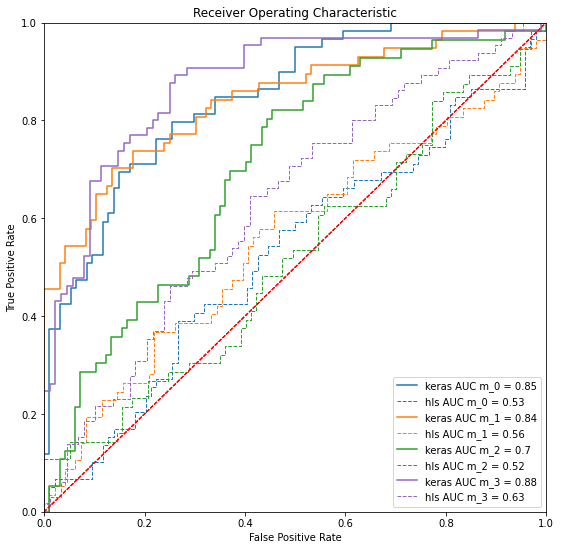

In [15]:
#load processed test data
X = np.load(X_npy, allow_pickle=True)
y = np.load(y_npy, allow_pickle=True)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

#use a quarter of the test_set to save time
for i in range(len(X)):
    quarter = int(len(X[i])/4)
    assert len(X) == len(y)
    X[i], y[i] = shuffle(X[i], y[i])
    X[i], y[i] = X[i][0:quarter],  y[i][0:quarter]

fig, ax = plt.subplots(figsize=(9, 9))
#perform inference
for index, X_data in enumerate(X):
    keras_pred = [0. for ind in X_data]
    hls_pred = [0. for ind in X_data]
    for file_idx, X_test in enumerate(X_data):
        keras_predictions = model.predict(X_test)
        keras_errors = np.mean(np.square(X_test-keras_predictions), axis=1)
        keras_pred[file_idx] = numpy.mean(keras_errors)
        
        hls_predictions = hls_model.predict(X_test)
        hls_errors = np.mean(np.square(X_test-hls_predictions), axis=1)
        hls_pred[file_idx] = numpy.mean(hls_errors)
        
    #generate auc and roc metrics
    y_test = y[index]
    k_fpr, k_tpr, k_threshold = metrics.roc_curve(y_test, keras_pred)
    k_roc_auc = metrics.auc(k_fpr, k_tpr)
    h_fpr, h_tpr, h_threshold = metrics.roc_curve(y_test, hls_pred)
    h_roc_auc = metrics.auc(h_fpr, h_tpr)


    plt.title('Receiver Operating Characteristic')
    plt.plot(k_fpr, k_tpr, label = 'keras AUC m_{} = {}'.format(index, round(k_roc_auc,2)), linewidth = 1.5, color=colors[index])
    plt.plot(h_fpr, h_tpr, label = 'hls AUC m_{} = {}'.format(index, round(h_roc_auc,2)), linewidth = 1, linestyle='--', color=colors[index])
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', linewidth=1)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()


## Synthesis

In [16]:
hls_model.build(csim=False,synth=True,export=True, vsynth=False)

hls4ml.report.read_vivado_report(output_dir)

Found 1 solution(s) in hls/pynqz2_anomaly_detector_m_axi_8_serial_prj/anomaly_detector_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../anomaly_detector_test.cpp in debug mode
   Compiling ../../../../firmware/anomaly_detector.cpp in debug mode
   Compiling ../../../../firmware/anomaly_detector_axi.cpp in debug mode
   Generating csim.exe
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'anomaly_detector_axi'
* Date:           Fri May  7 10:27:57 2021

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        anomaly_detector_prj
* Solution:       solution1
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing (ns): 


## Resource Reference

See the resources availables on different boards.

```
+-----------------+---------+-------+--------+-------+-----+                    
|                 |               Resource                 |
+-----------------+---------+-------+--------+-------+-----+
|      Board      | BRAM_18K| DSP48E|   FF   |  LUT  | URAM|
+-----------------+---------+-------+--------+-------+-----+
|   PYNQ-Z1/Z2    |      280|    220|  106400|  53200|    0|
+-----------------+---------+-------+--------+-------+-----+
|     MiniZed     |      100|     66|   28800|  14400|    0|
+-----------------+---------+-------+--------+-------+-----+
``` 

## Generate .dat Files

The .dat files are used
- during the following `csim` step
- to generate the header files for SDK

In [17]:
f = open(output_dir + '/tb_data/tb_input_features.dat', 'w')

# This is under the assumption that 
# 1. all the machines have the same number of wave files
# 2. all of the wave files have the same number of frames
# 3. all of the frames have the same length

machine_count=len(X)
wav_count=len(X[0])
frame_count=len(X[0][0])
frame_length=len(X[0][0][0])

print('Machine count: {}'.format(machine_count))
print('Wave count: {}'.format(wav_count))
print('Frame count: {}'.format(frame_count))
print('Frame length: {}'.format(frame_length))

# Save the first N frames of the first wave file of the first machine
N=1
for j in range(N):
    for k in range(frame_length):
        f.write('{} '.format(X[0][0][j][k]))
    f.write('\n')
f.close()

f = open(output_dir + '/tb_data/tb_output_predictions.dat', 'w')
for i in range(N):
    f.write('{} '.format(y[0][i]))
    f.write('\n')
f.close()

Machine count: 4
Wave count: 153
Frame count: 196
Frame length: 128


## Run Vivado HLS csim

At this step we generate simulation traces out from the hls4ml-model.

Run the following cell to run Vivado HLS GUI:

In [18]:
!cd $output_dir && vivado_hls -p $acc_name\_prj


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'giuseppe' on host 'frodo' (Linux_x86_64 version 4.15.0-142-generic) on Fri May 07 10:40:36 EDT 2021
INFO: [HLS 200-10] On os Ubuntu 18.04.5 LTS
INFO: [HLS 200-10] In directory '/home/giuseppe/teaching/spring_2021/csee_e6868/hls4ml-tutorial-julesmuhizi/deploy/vivado_flow/hls/pynqz2_anomaly_detector_m_axi_8_serial_prj'
INFO: [HLS 200-10] Bringing up Vivado HLS GUI ... 
INFO: [Common 17-206] Exiting vivado_hls at Fri May  7 10:41:34 2021...


**IMPORTANT** Click the button to `Run C Simulation`.

This will generate simulation traces with fixed-point arythmetic.

When completed close Vivado HLS GUI.

## Integrate IP in a Vivado Project and Generate Bitstream

In [19]:
!cd sys/$board_name && make clean sys-gui ACC=$acc_name INTERFACE=$interface

rm -rf *.log *.txt *.jou *.str anomaly_detector_project NA
vivado -source tcl/script.tcl -mode gui -tclargs anomaly_detector m_axi

****** Vivado v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

start_gui
INFO: [Common 17-206] Exiting Vivado at Fri May  7 14:07:56 2021...


**TODO** Tell the user how to visualize the `Block Diagram` to get a better understanding of the IP integration with both Zynq and MicroBlaze PS.

## Configure Software in Vivado SDK and Run HW/SW on the Board

Create Vivado SDK project.

- `make sdk` to configure an application with register polling
- `make sdk-irq` to configure an application with interrupts (default)

In [ ]:
!source /tools/Xilinx/Vivado/2019.1/settings64.sh && cd sdk/$board_name && make clean sdk ACC=$acc_name SAMPLE_COUNT=10

In [ ]:
!xterm -e "sleep 1 && source /tools/Xilinx/Vivado/2019.1/settings64.sh && cd sdk/$board_name && make gui && sleep infinity"


You can open a serial console, for example
```
sudo minicom -D /dev/ttyUSB0
```
and see something like

![serial-console](doc/serial_console.png)